ÉTAPE 3 — ÉVALUATION PERFORMANCE: owlready2 vs SPARQL


Benchmark complet: temps, mémoire, qualité chunks

In [1]:

from owlready2 import get_ontology, default_world
import pickle
import re
import time
import psutil
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd


In [2]:
print("🚀 BENCHMARK owlready2 vs SPARQL...")


🚀 BENCHMARK owlready2 vs SPARQL...


In [3]:
onto = get_ontology("hp.owl").load()
print(f"Ontologie: {len(list(onto.classes())):,} classes")

Ontologie: 32,044 classes


 MÉTHODE 1: owlready2 BOUCLES PYTHON

In [4]:
print("\n⏱️  MÉTHODE 1: owlready2 (boucles Python)...")



⏱️  MÉTHODE 1: owlready2 (boucles Python)...


In [5]:
start_time = time.time()


In [6]:

# Fonctions owlready2 (votre code)
def clean_text(text):
    if not isinstance(text, str) or not text.strip(): return ""
    cleaned = re.sub(r'\s+', ' ', text.replace('\n', ' ').replace(';', ',')).strip()
    return cleaned[:200] + "..." if len(cleaned) > 200 else cleaned


In [7]:
def get_label_owl(cls):
    try: return str(cls.label[0]).strip() if cls.label else cls.name.replace("_", ":")
    except: return cls.name.replace("_", ":")


In [8]:
def get_definition_owl(cls):
    if cls.comment: return clean_text(str(cls.comment[0]))
    return f"Symptôme clinique (HP:{cls.name.replace('_', ':')})"


 Extraction owlready2

In [9]:
owl_start = time.time()
all_hp_owl = [c for c in onto.classes() if c.name.startswith("HP_") and len(c.name) > 3]
owl_docs, owl_meta, owl_ids = [], [], []
for cls in all_hp_owl:
    label = get_label_owl(cls)
    definition = get_definition_owl(cls)
    code = cls.name.replace("_", ":")
    owl_docs.append(f"[Symptôme] : {label}\nDéfinition : {definition}\nCode HPO : {code}\nSource : Ontologie HPO")
    owl_meta.append({"method": "owlready2", "is_leaf": len(list(cls.subclasses())) == 0})
    owl_ids.append(code)
owl_time = time.time() - owl_start


Mémoire


In [10]:
owl_memory = psutil.Process().memory_info().rss / 1024**2  # MB

print(f"✅ owlready2: {len(owl_docs):,} chunks | {owl_time:.2f}s | {owl_memory:.1f}MB")


✅ owlready2: 19,903 chunks | 2.72s | 385.5MB


MÉTHODE 2: SPARQL

In [11]:
print("\n⏱️  MÉTHODE 2: SPARQL...")



⏱️  MÉTHODE 2: SPARQL...


In [12]:
sparql_start = time.time()

SPARQL query 


In [13]:
sparql_query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
SELECT ?class ?label ?comment WHERE {
  ?class a owl:Class .
  OPTIONAL { ?class rdfs:label ?label }
  OPTIONAL { ?class rdfs:comment ?comment }
  FILTER(STRSTARTS(STR(?class), "http://purl.obolibrary.org/obo/HP_"))
}
"""


In [14]:
sparql_results = list(default_world.sparql(sparql_query))


Traitement SPARQL

In [15]:
sparql_docs, sparql_meta, sparql_ids = [], [], []
for result in sparql_results:
    cls, label, comment = result[0], result[1], result[2]
    cls_name = str(cls).split("HP_")[-1].replace("_", ":")
    label_str = str(label) if label else cls_name
    comment_str = clean_text(str(comment)) if comment else "Symptôme clinique documenté"
    
    sparql_docs.append(f"[Symptôme] : {label_str}\nDéfinition : {comment_str}\nCode HPO : {cls_name}\nSource : Ontologie HPO")
    sparql_meta.append({"method": "sparql", "is_leaf": True})  # Simplified
    sparql_ids.append(cls_name)



In [16]:
sparql_time = time.time() - sparql_start
sparql_memory = psutil.Process().memory_info().rss / 1024**2

In [17]:
print(f"✅ SPARQL: {len(sparql_docs):,} chunks | {sparql_time:.2f}s | {sparql_memory:.1f}MB")


✅ SPARQL: 19,903 chunks | 1.19s | 403.1MB


COMPARAISON PERFORMANCE 

In [18]:
print("\n" + "="*60)
print("🏆 COMPARAISON PERFORMANCE")
print("="*60)

perf_df = pd.DataFrame({
    "Méthode": ["owlready2", "SPARQL"],
    "Chunks": [len(owl_docs), len(sparql_docs)],
    "Temps (s)": [owl_time, sparql_time],
    "Mémoire (MB)": [owl_memory, sparql_memory],
    "Chunks/s": [len(owl_docs)/owl_time, len(sparql_docs)/sparql_time]
})




🏆 COMPARAISON PERFORMANCE


In [19]:
print(perf_df.round(2))
print(f"\n🎯 VITESSE: {'SPARQL' if sparql_time < owl_time else 'owlready2'} {min(sparql_time, owl_time)/max(sparql_time, owl_time):.2f}x plus rapide")


     Méthode  Chunks  Temps (s)  Mémoire (MB)  Chunks/s
0  owlready2   19903       2.72        385.54   7315.61
1     SPARQL   19903       1.19        403.12  16718.60

🎯 VITESSE: SPARQL 0.44x plus rapide


QUALITÉ CHUNKS

In [20]:
print("\n📊 QUALITÉ CHUNKS")
owl_qual = sum(1 for doc in owl_docs[:1000] if len(doc.split()) > 10) / 1000 * 100  # % chunks riches
sparql_qual = sum(1 for doc in sparql_docs[:1000] if len(doc.split()) > 10) / 1000 * 100
print(f"• owlready2: {owl_qual:.1f}% chunks riches (mots > 10)")
print(f"• SPARQL: {sparql_qual:.1f}% chunks riches")



📊 QUALITÉ CHUNKS
• owlready2: 100.0% chunks riches (mots > 10)
• SPARQL: 100.0% chunks riches


VISUALISATION

Performance

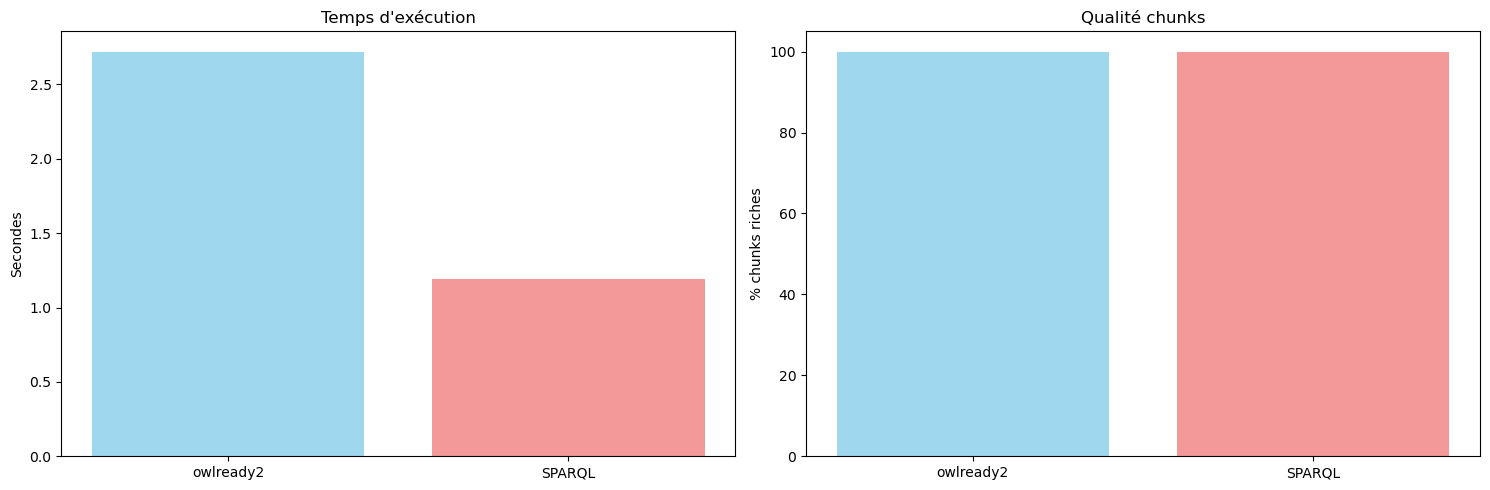

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

x = range(2)
methods = ["owlready2", "SPARQL"]
axes[0].bar(x, [owl_time, sparql_time], color=['skyblue', 'lightcoral'], alpha=0.8)
axes[0].set_title("Temps d'exécution")
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods)
axes[0].set_ylabel("Secondes")

# Qualité
axes[1].bar(x, [owl_qual, sparql_qual], color=['skyblue', 'lightcoral'], alpha=0.8)
axes[1].set_title("Qualité chunks")
axes[1].set_xticks(x)
axes[1].set_xticklabels(methods)
axes[1].set_ylabel("% chunks riches")

plt.tight_layout()
plt.show()
